In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from commpy.utilities  import signal_power, upsample
from commpy.modulation import QAMModem
from utils.dsp import firFilter, pulseShape, lowPassFIR, edc, fourthPowerFOE, dbp, cpr
from utils.models import mzm, linFiberCh, iqm, ssfm, edfa, phaseNoise, coherentReceiver, manakov_ssf
from utils.tx import simpleWDMTx
from utils.core import parameters

from scipy import signal
import scipy.constants as const
from numba import njit

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

# Simulation of coherent WDM systems

## Coherent WDM system

### Transmitter

In [4]:
help(simpleWDMTx)

Help on function simpleWDMTx in module utils.tx:

simpleWDMTx(param)
    Simple WDM transmitter
    
    Generates a complex baseband waveform representing a WDM signal with arbitrary number of carriers
    
    :param.M: QAM order [default: 16]
    :param.Rs: carrier baud rate [baud][default: 32e9]
    :param.SpS: samples per symbol [default: 16]
    :param.Nbits: total number of bits per carrier [default: 60000]
    :param.pulse: pulse shape ['nrz', 'rrc'][default: 'rrc']
    :param.Ntaps: number of coefficients of the rrc filter [default: 4096]
    :param.alphaRRC: rolloff do rrc filter [default: 0.01]
    :param.Pch_dBm: launched power per WDM channel [dBm][default:-3 dBm]
    :param.Nch: number of WDM channels [default: 5]
    :param.Fc: central frequency of the WDM spectrum [Hz][default: 193.1e12 Hz]
    :param.freqSpac: frequency spacing of the WDM grid [Hz][default: 40e9 Hz]
    :param.Nmodes: number of polarization modes [default: 1]



In [5]:
help(ssfm)

Help on function ssfm in module utils.models:

ssfm(Ei, Fs, paramCh)
    Split-step Fourier method (symmetric, single-pol.)
    
    :param Ei: input signal
    :param Fs: sampling frequency of Ei [Hz]
    :param paramCh: object with physical parameters of the optical channel
    
    :paramCh.Ltotal: total fiber length [km][default: 400 km]
    :paramCh.Lspan: span length [km][default: 80 km]
    :paramCh.hz: step-size for the split-step Fourier method [km][default: 0.5 km]
    :paramCh.alpha: fiber attenuation parameter [dB/km][default: 0.2 dB/km]
    :paramCh.D: chromatic dispersion parameter [ps/nm/km][default: 16 ps/nm/km]
    :paramCh.gamma: fiber nonlinear parameter [1/W/km][default: 1.3 1/W/km]
    :paramCh.Fc: carrier frequency [Hz] [default: 193.1e12 Hz]
    :paramCh.amp: 'edfa', 'ideal', or 'None. [default:'edfa']
    :paramCh.NF: edfa noise figure [dB] [default: 4.5 dB]    
    
    :return Ech: propagated signal



In [6]:
#@jit(nopython=True)
def pbs(E, θ=0):
    """
    Polarization beam splitter (pbs)
    
    :param E: input pol. multiplexed field [2d nparray]
    :param θ: rotation angle of input field [rad][default: 0 rad]
    
    :return: Ex output single pol. field [1d nparray]
    :return: Ey output single pol. field [1d nparray]
    
    """  
    try:
        assert E.shape[1] == 2, 'E need to be a N-by-2 2d nparray or a 1d nparray'
    except IndexError:
        E = np.repeat(E, 2).reshape(-1,2)
        E[:,1] = 0
        
    rot = np.array([[np.cos(θ), -np.sin(θ)],[np.sin(θ), np.cos(θ)]])+1j*0

    E = E@rot
    
    Ex = E[:,0]
    Ey = E[:,1]    

    return Ex, Ey

In [7]:
def pdmCoherentReceiver(Es, Elo, θsig=0, Rdx=1, Rdy=1):
    """
    Polarization multiplexed coherent optical front-end
    
    :param Es: input signal field [2d nparray]
    :param Elo: input LO field [nparray]
    :param θsig: polarization rotation angle [rad][default: 0]
    :param Rdx: photodiode resposivity pol.X [scalar]
    :param Rdy: photodiode resposivity pol.Y [scalar]
    
    :return: downconverted signal after balanced detection    
    """
    assert Rdx > 0 and Rdy >0, 'PD responsivity should be a positive scalar'
    assert len(Es) == len(Elo), 'Es and Elo need to have the same number of samples'
            
    Elox, Eloy = pbs(Elo, θ = np.pi/4) # split LO into two orthogonal polarizations
    Esx,  Esy  = pbs(Es, θ = θsig)     # split signal into two orthogonal polarizations
    
    Sx = coherentReceiver(Esx, Elox, Rd=Rdx) # coherent detection of pol.X
    Sy = coherentReceiver(Esy, Eloy, Rd=Rdy) # coherent detection of pol.Y
    
    Sx = Sx.reshape(len(Sx),1)
    Sy = Sy.reshape(len(Sy),1)
    
    return np.concatenate((Sx, Sy), axis=1)

In [8]:
@njit
def LLRcalc(rxSymb, M, σ2, constSymb):
    
    b = int(np.log2(M))
    
    LLRs = np.zeros(len(rxSymb)*b)
    
    for i in np.arange(len(rxSymb)):
        symb = rxSymb[i]
        for bit_index in np.arange(b):
            llr_num = 0
            llr_den = 0
            for bit_value, symbol in enumerate(constSymb):
                if (bit_value >> bit_index) & 1:
                    llr_num += np.exp((-abs(symb - symbol)**2)/σ2)                    
                else:
                    llr_den += np.exp((-abs(symb - symbol)**2)/σ2)
            
            if llr_num == 0:
                llr_num = 10**-200
                
            if llr_den == 0:
                llr_den = 10**-200
                    
            LLRs[i * b + b - 1 - bit_index] = np.log(llr_num)-np.log(llr_den)
    
    return LLRs

In [9]:
def fastBERcalc(rx, tx, mod):
    """
    BER calculation
    """
    
    # We want all the signal sequences to be disposed in columns:        
    try:
        if rx.shape[1] > rx.shape[0]:
            rx = rx.T       
    except IndexError:
        rx  = rx.reshape(len(rx),1)       
        
    try:        
        if tx.shape[1] > tx.shape[0]:
            tx = tx.T
    except IndexError:        
        tx = tx.reshape(len(tx),1)

    nModes = int(tx.shape[1]) # number of sinal modes
    SNR    = np.zeros(nModes)
    BER    = np.zeros(nModes)
    
    # symbol normalization
    for k in range(0, nModes):       
        rx[:,k] = rx[:,k]/np.sqrt(signal_power(rx[:,k]))
        tx[:,k] = tx[:,k]/np.sqrt(signal_power(tx[:,k]))
        
    for k in range(0, nModes):
        # correct (possible) phase ambiguity
        rot = np.mean(tx[:,k]/rx[:,k])
        rx[:,k]  = rot*rx[:,k]
        
        # estimate SNR of the received constellation
        SNR[k] = signal_power(tx[:,k])/signal_power(rx[:,k]-tx[:,k])

        # hard decision demodulation of the received symbols    
        brx = mod.demodulate(np.sqrt(mod.Es)*rx[:,k], demod_type = 'hard') 
        btx = mod.demodulate(np.sqrt(mod.Es)*tx[:,k], demod_type = 'hard') 

        err = np.logical_xor(brx, btx)
        BER[k] = np.mean(err)
        
    return BER, 10*np.log10(SNR)

def monteCarloGMI(rx, tx, mod):
    """
    GMI calculation
    """
    
    # We want all the signal sequences to be disposed in columns:        
    try:
        if rx.shape[1] > rx.shape[0]:
            rx = rx.T       
    except IndexError:
        rx  = rx.reshape(len(rx),1)       
        
    try:        
        if tx.shape[1] > tx.shape[0]:
            tx = tx.T
    except IndexError:        
        tx = tx.reshape(len(tx),1)

    nModes = int(tx.shape[1]) # number of sinal modes
    GMI    = np.zeros(nModes)
        
    # symbol normalization
    for k in range(0, nModes):       
        rx[:,k] = rx[:,k]/np.sqrt(signal_power(rx[:,k]))
        tx[:,k] = tx[:,k]/np.sqrt(signal_power(tx[:,k]))
        
    for k in range(0, nModes):
        # correct (possible) phase ambiguity
        rot = np.mean(tx[:,k]/rx[:,k])
        rx[:,k]  = rot*rx[:,k]
        
        # estimate SNR of the received constellation
        σ2 = signal_power(rx[:,k]-tx[:,k])
              
        # hard decision demodulation of the transmitted symbols
        btx = mod.demodulate(np.sqrt(mod.Es)*tx[:,k], demod_type = 'hard')
                        
        # soft demodulation of the received symbols    
      #  LLRs = mod.demodulate(np.sqrt(mod.Es)*rx[:,k], demod_type = 'soft', noise_var = σ2) 
        LLRs = LLRcalc(np.sqrt(mod.Es)*rx[:,k], mod.m, σ2, mod._constellation) 
        LLRs[LLRs >= 300] = 300
        LLRs[LLRs < -300] = -300
           
        # Compute bitwise MIs and their sum
        m = int(np.log2(mod.m))
        
        MIperBitPosition = np.zeros(m)
        LLRs *= -1
        
        for n in range(0, m):
            MIperBitPosition[n] = 1 - np.mean(np.log2(1 + np.exp( (2*btx[n::m]-1)*LLRs[n::m]) ) )
                        
        GMI[k] = np.sum(MIperBitPosition)
                
    return GMI

In [10]:
#GMI = monteCarloGMI(y_EQ[1:10000,:], d[1:10000,:], mod)

#print(GMI)

## Polarization multiplexed WDM signal

**signal generation**

In [11]:
# Parâmetros do transmissor:
param = parameters()
param.M   = 16           # ordem do formato de modulação
param.Rs  = 32e9         # taxa de sinalização [baud]
param.SpS = 8            # número de amostras por símbolo
param.Nbits = 400000     # número de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 4096       # número de coeficientes do filtro RRC
param.alphaRRC = 0.01    # rolloff do filtro RRC
param.Pch_dBm = 1        # potência média por canal WDM [dBm]
param.Nch     = 5        # número de canais WDM
param.Fc      = 193.1e12 # frequência central do espectro WDM
param.freqSpac = 40e9    # espaçamento em frequência da grade de canais WDM
param.Nmodes = 2         # número de modos de polarização

sigWDM_Tx, symbTx_, param = simpleWDMTx(param)

freqGrid = param.freqGrid

Mode #0
channel 1 power : -2.01 dBm, fc : 193.0200 THz
channel 2 power : -2.01 dBm, fc : 193.0600 THz
channel 3 power : -2.01 dBm, fc : 193.1000 THz
channel 4 power : -2.01 dBm, fc : 193.1400 THz
channel 5 power : -2.01 dBm, fc : 193.1800 THz
Mode #1
channel 1 power : -2.01 dBm, fc : 193.0200 THz
channel 2 power : -2.01 dBm, fc : 193.0600 THz
channel 3 power : -2.01 dBm, fc : 193.1000 THz
channel 4 power : -2.01 dBm, fc : 193.1400 THz
channel 5 power : -2.01 dBm, fc : 193.1800 THz
total WDM signal power: 7.99 dBm


**Nonlinear fiber propagation with the split-step Fourier method**

In [32]:
linearChannel = False

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 800   # km
paramCh.Lspan  = 80    # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.hz = 0.5       # km
paramCh.gamma = 1.3    # 1/(W.km)

if linearChannel:
    paramCh.hz = paramCh.Lspan 
    paramCh.gamma = 0  

Fs = param.Rs*param.SpS
sigWDM, paramCh = manakov_ssf(sigWDM_Tx, Fs, paramCh) 


receivedSignal = sigWDM.copy()
transmSymbols  = symbTx_.copy()

**Optical WDM spectrum before and after transmission**

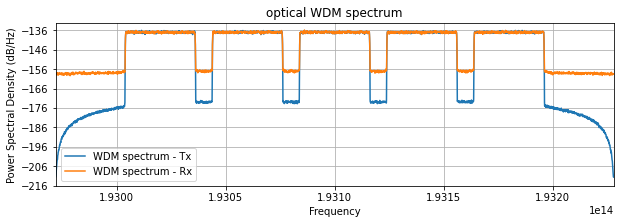

In [33]:
# plot psd
plt.figure()
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

**WDM channels coherent detection and demodulation**

Demodulating channel #2 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 0.00 kHz, FO: 0.00 MHz



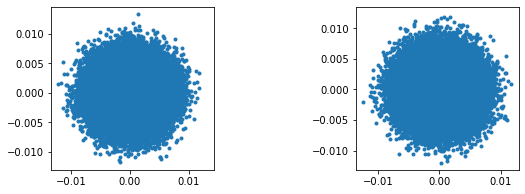

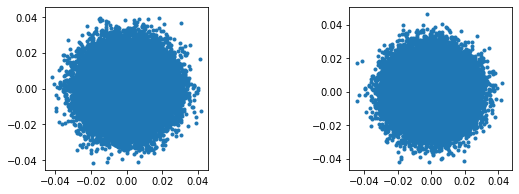

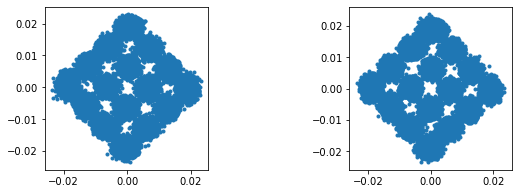

In [34]:
### Receiver

# parameters
chIndex  = 2    # index of the channel to be demodulated
plotPSD  = True

Fa = param.SpS*param.Rs
Fc = paramCh.Fc
Ta = 1/Fa
mod = QAMModem(m=param.M)

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = transmSymbols[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 0*64e6                  # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 0*100e3               # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig = 0, Rdx=1, Rdy=1)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

# Rx filtering

# Matched filter
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

# CD compensation
sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fa)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

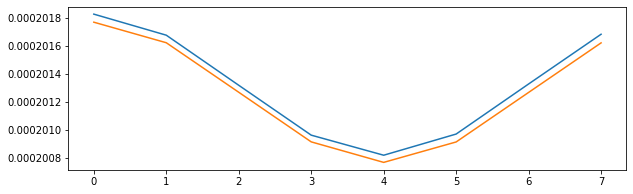

In [35]:
# simple timing recovery
sampDelay = np.zeros(sigRx.shape[1])
for k in range(0, sigRx.shape[1]):
    a = sigRx[:,k].reshape(sigRx.shape[0],1)
    varVector = np.var(a.reshape(-1,param.SpS), axis=0) # finds best sampling instant
    plt.plot(varVector)
    sampDelay[k] = np.where(varVector == np.amax(varVector))[0][0]

# downsampling
sigRx_ = sigRx[::int(param.SpS/2),:]
for k in range(0, sigRx.shape[1]):
    sigRx_[:,k] = sigRx[int(sampDelay[k])::int(param.SpS/2),k]

sigRx = sigRx_

In [36]:
# calculate time delay due to walkoff

symbDelay = np.zeros(sigRx.shape[1])
for k in range(0, sigRx.shape[1]):
    symbDelay[k] = np.argmax(signal.correlate(np.abs(symbTx[:,k]), np.abs(sigRx[::2,k])))-symbTx.shape[0]+1
    print(symbDelay[k])

# compensate walkoff time delay
for k in range(len(symbDelay)):    
    symbTx[:,k] = np.roll(symbTx[:,k], -int(symbDelay[k]))

0.0
0.0


In [37]:
# discard = 1000
# ind = np.arange(discard, sigRx.size-discard)

# # symbol normalization
# sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# # plot constellation after CD compensation
# ax2.plot(sigRx.real, sigRx.imag,'.', markersize=4)
# ax2.axis('square')
# ax2.title.set_text('After CD comp.')
# ax2.grid()

# # calculate time delay due to walkoff
# symbDelay = np.argmax(signal.correlate(np.abs(symbTx), np.abs(sigRx)))-sigRx.size+1 

# # compensate walkoff time delay
# sigRx = np.roll(sigRx, symbDelay)

# # symbol normalization
# sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# # estimate and compensate LO frequency offset
# fo = fourthPowerFOE(sigRx, 1/param.Rs)
# print('Estimated FO : %3.4f MHz'%(fo/1e6))

# sigRx = sigRx*np.exp(-1j*2*π*fo*np.arange(0,len(sigRx))/param.Rs)

# # plot constellation after LO frequency offset compensation
# ax3.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
# ax3.axis('square')
# ax3.title.set_text('After CFR (4th-power FOE)')
# ax3.grid()

# # compensate phase noise (carrier phase recovery - cpr)
# windowSize = 30
# c  = mod.constellation/np.sqrt(mod.Es)
# sigRx, ϕ, θ = cpr(sigRx, windowSize, c, symbTx)

# # plot phases estimated by cpr
# phaseOffSet = np.mean(np.roll(ϕ_pn_lo[::param.SpS], symbDelay)-θ)
# plt.figure()
# plt.plot(np.roll(ϕ_pn_lo[::param.SpS], symbDelay), label='phase of the LO');
# plt.plot(θ+phaseOffSet, label='phase estimated by CPR');
# plt.grid()
# plt.xlim(0,θ.size)
# plt.legend();

# # correct (possible) phase ambiguity
# rot = np.mean(symbTx[ind]/sigRx[ind])
# sigRx  = rot*sigRx

# # symbol normalization
# sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# # plot constellation after cpr
# ax4.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
# ax4.axis('square')
# ax4.title.set_text('After CPR (DD-PLL)')
# ax4.grid()

# # estimate SNR of the received constellation
# SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# # hard decision demodulation of the received symbols    
# bitsRx = mod.demodulate(np.sqrt(mod.Es)*sigRx, demod_type = 'hard') 
# bitsTx = mod.demodulate(np.sqrt(mod.Es)*symbTx, demod_type = 'hard') 

# err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
#                      bitsTx[discard:bitsTx.size-discard])
# BER = np.mean(err)

# print('Estimated SNR = %.2f dB \n'%(10*np.log10(SNR)))
# print('Total counted bits = %d  '%(err.size))
# print('Total of counted errors = %d  '%(err.sum()))
# print('BER = %.2e  '%(BER))

# plt.figure()
# plt.plot(err,'o', label = 'errors location')
# plt.legend()
# plt.grid()

In [38]:
# from scipy.stats.kde import gaussian_kde

# y = (sigRx[ind]).real
# x = (sigRx[ind]).imag

# k = gaussian_kde(np.vstack([x, y]))
# k.set_bandwidth(bw_method=k.factor/4)

# xi, yi = 1.1*np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# plt.figure(figsize=(5,5))
# plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1, shading='auto');

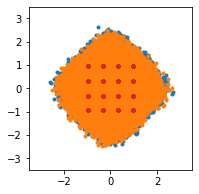

In [39]:
from numpy.matlib import repmat
from tqdm.notebook import tqdm

x = sigRx
d = symbTx

x = x.reshape(len(x),2)/np.sqrt(signal_power(x))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))

#θ = np.pi/3

#rot = np.array([[np.cos(θ), -np.sin(θ)],[np.sin(θ), np.cos(θ)]])

#x = x@rot

plt.plot(x.real, x.imag,'.');
plt.plot(d.real, d.imag,'.');
plt.axis('square')
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5);

In [40]:
from numba import njit, jit

def mimoAdaptEqualizer(x, dx=[], paramEq=[]):              
    """
    N-by-N MIMO adaptive equalizer
    
    """
   
    # check input parameters
    numIter    = getattr(paramEq, 'numIter', 1)
    nTaps      = getattr(paramEq, 'nTaps', 15)
    mu         = getattr(paramEq, 'mu', 1e-3)
    SpS        = getattr(paramEq, 'SpS', 2)
    H          = getattr(paramEq, 'H', [])
    L          = getattr(paramEq, 'L', [])
    Hiter      = getattr(paramEq, 'Hiter', [])
    storeCoeff = getattr(paramEq, 'storeCoeff', False)
    alg        = getattr(paramEq, 'alg', ['nlms'])
    M          = getattr(paramEq, 'M', 4)    
    
    # We want all the signal sequences to be disposed in columns:
    if not len(dx):
        dx = x.copy()
        
    try:
        if x.shape[1] > x.shape[0]:
            x = x.T       
    except IndexError:
        x  = x.reshape(len(x),1)       
        
    try:        
        if dx.shape[1] > dx.shape[0]:
            dx = dx.T
    except IndexError:        
        dx = dx.reshape(len(dx),1)

    nModes = int(x.shape[1]) # number of sinal modes (order of the MIMO equalizer)
    
    Lpad    = int(np.floor(nTaps/2))
    zeroPad = np.zeros((Lpad, nModes), dtype='complex')
    x = np.concatenate((zeroPad, x, zeroPad)) # pad start and end of the signal with zeros
    
    # Defining training parameters:
    mod = QAMModem(m=M) # commpy QAM constellation modem object
    constSymb = mod.constellation/np.sqrt(mod.Es) # complex-valued constellation symbols

    if not L: # if L is not defined
        L = [int(np.fix((len(x)-nTaps)/SpS+1))] # Length of the output (1 sample/symbol) of the training section       
    
    if len(H) == 0: # if H is not defined
        H  = np.zeros((nModes**2, nTaps), dtype='complex')
        
        for initH in range(0, nModes): # initialize filters' taps
            H[initH + initH*nModes, int(np.floor(H.shape[1]/2))] = 1 # Central spike initialization
           
    # Equalizer training:
    for indIter in tqdm(range(0, numIter)):
        print(alg[0],'training iteration #%d'%indIter)        
        yEq, H, errSq, Hiter = coreAdaptEq(x, dx, SpS, H, L[0], mu, nTaps, storeCoeff, alg[0], constSymb)               
        print(alg[0],'MSE = %.6f.'%np.nanmean(errSq))
        
    return  yEq, H, errSq, Hiter

@jit(nopython=True)
def coreAdaptEq(x, dx, SpS, H, L, mu, nTaps, storeCoeff, alg, constSymb):
    """
    Adaptive equalizer core processing function
    
    """
    
    # allocate variables
    nModes  = int(x.shape[1])
    indTaps = np.arange(0, nTaps) 
    indMode = np.arange(0, nModes)
    
    errSq   = np.empty((nModes, L))
    yEq     = x[0:L].copy()    
    yEq[:]  = np.nan    
    outEq   = np.array([[0+1j*0]]).repeat(nModes).reshape(nModes, 1)
    
    if storeCoeff:
        Hiter = np.array([[0+1j*0]]).repeat((nModes**2)*nTaps*L).reshape(nModes**2, nTaps, L)
    else:
        Hiter = np.array([[0+1j*0]]).repeat((nModes**2)*nTaps).reshape(nModes**2, nTaps, 1)
        
    # Radii cma, rde
    Rcma = (np.mean(np.abs(constSymb)**4)/np.mean(np.abs(constSymb)**2))*np.ones((1, nModes))+1j*0          
    Rrde = np.unique(np.abs(constSymb))
        
    for ind in range(0, L):       
        outEq[:] = 0
            
        indIn = indTaps + ind*SpS # simplify indexing and improve speed

        # pass signal sequence through the equalizer:
        for N in range(0, nModes):
            inEq   = x[indIn, N].reshape(len(indIn), 1) # slice input coming from the Nth mode            
            outEq += H[indMode+N*nModes,:]@inEq         # add contribution from the Nth mode to the equalizer's output                 
                        
        yEq[ind,:] = outEq.T        
                    
        # update equalizer taps acording to adaptive specified 
        # training algorithm and save squared error:        
        if alg == 'nlms':
            H, errSq[:,ind] = nlmsUp(x[indIn, :], dx[ind,:], outEq, mu, H, nModes)
        elif alg == 'cma':
            H, errSq[:,ind] = cmaUp(x[indIn, :], Rcma, outEq, mu, H, nModes) 
        elif alg == 'ddlms':
            H, errSq[:,ind] = ddlmsUp(x[indIn, :], constSymb, outEq, mu, H, nModes)
        elif alg == 'rde':
            H, errSq[:,ind] = rdeUp(x[indIn, :], Rrde, outEq, mu, H, nModes)
        
        if storeCoeff:
            Hiter[:,:, ind] = H  
        else:
            Hiter[:,:, 1] = H
            
    return yEq, H, errSq, Hiter

@jit(nopython=True)
def nlmsUp(x, dx, outEq, mu, H, nModes):
    """
    coefficient update with the NLMS algorithm    
    """          
    indMode = np.arange(0, nModes)    
    err = dx - outEq.T # calculate output error for the NLMS algorithm 
    
    errDiag = np.diag(err[0]) # define diagonal matrix from error array
    
    # update equalizer taps 
    for N in range(0, nModes):
            indUpdTaps = indMode+N*nModes # simplify indexing and improve speed
            inAdapt = x[:, N].T/np.linalg.norm(x[:,N])**2 # NLMS normalization
            inAdaptPar = inAdapt.repeat(nModes).reshape(len(x), -1).T # expand input to parallelize tap adaptation
            H[indUpdTaps,:] = H[indUpdTaps,:] + mu*errDiag@np.conj(inAdaptPar) # gradient descent update   

    return H, np.abs(err)**2

@jit(nopython=True)
def ddlmsUp(x, constSymb, outEq, mu, H, nModes):
    """
    coefficient update with the DDLMS algorithm    
    """      
    indMode    = np.arange(0, nModes)
    outEq      = outEq.T
    decided    = outEq.copy()
    decided[:] = np.nan
       
    for k in range(0, outEq.shape[1]):
        indSymb = np.argmin(np.abs(outEq[0,k] - constSymb))
        decided[0,k] = constSymb[indSymb]
                
    err = decided - outEq # calculate output error for the DDLMS algorithm   

    errDiag = np.diag(err[0]) # define diagonal matrix from error array
   
    # update equalizer taps 
    for N in range(0, nModes):
            indUpdTaps = indMode+N*nModes # simplify indexing
            inAdapt = x[:, N].T
            inAdaptPar = inAdapt.repeat(nModes).reshape(len(x), -1).T # expand input to parallelize tap adaptation
            H[indUpdTaps,:] = H[indUpdTaps,:] + mu*errDiag@np.conj(inAdaptPar) # gradient descent update   

    return H, np.abs(err)**2


@jit(nopython=True)
def cmaUp(x, R, outEq, mu, H, nModes):
    """
    coefficient update with the CMA algorithm    
    """      
    indMode = np.arange(0, nModes)
    outEq = outEq.T
    err   = R - np.abs(outEq)**2 # calculate output error for the CMA algorithm 

    prodErrOut = np.diag(err[0])@np.diag(outEq[0]) # define diagonal matrix 
    
    # update equalizer taps  
    for N in range(0, nModes):
            indUpdTaps = indMode+N*nModes # simplify indexing
            inAdapt = x[:, N].T
            inAdaptPar = inAdapt.repeat(nModes).reshape(len(x), -1).T # expand input to parallelize tap adaptation
            H[indUpdTaps,:] = H[indUpdTaps,:] + mu*prodErrOut@np.conj(inAdaptPar) # gradient descent update   

    return H, np.abs(err)**2

@jit(nopython=True)
def rdeUp(x, R, outEq, mu, H, nModes):
    """
    coefficient update with the RDE algorithm    
    """      
    indMode    = np.arange(0, nModes)
    outEq      = outEq.T    
    decidedR    = outEq.copy()
    decidedR[:] = np.nan
    
    # find closest constellation radius
    for k in range(0, outEq.shape[1]):
        indR = np.argmin(np.abs(R - np.abs(outEq[0,k])))
        decidedR[0,k] = R[indR]
        
    err  = decidedR**2 - np.abs(outEq)**2 # calculate output error for the RDE algorithm 
    
    prodErrOut = np.diag(err[0])@np.diag(outEq[0]) # define diagonal matrix 
    
    # update equalizer taps 
    for N in range(0, nModes):
            indUpdTaps = indMode+N*nModes # simplify indexing
            inAdapt = x[:, N].T
            inAdaptPar = inAdapt.repeat(nModes).reshape(len(x), -1).T # expand input to parallelize tap adaptation
            H[indUpdTaps,:] = H[indUpdTaps,:] + mu*prodErrOut@np.conj(inAdaptPar) # gradient descent update   

    return H, np.abs(err)**2

In [50]:
paramEq = parameters()
paramEq.nTaps = 35
paramEq.SpS   = 2
paramEq.mu    = 5e-3
paramEq.numIter = 3
paramEq.storeCoeff = False
paramEq.alg   = ['nlms']
paramEq.M     = 16
paramEq.L = [10000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

paramEq = parameters()
paramEq.nTaps = 35
paramEq.SpS   = 2
paramEq.mu    = 1e-3
paramEq.numIter = 1
paramEq.storeCoeff = False
paramEq.alg   = ['ddlms']
paramEq.M     = 16
paramEq.H = H

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

# y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(np.matlib.repmat(x,1,3),\
#                                            dx=np.matlib.repmat(d,1,3),\
#                                            paramEq=paramEq)

discard = 1000
ind = np.arange(discard, d.shape[0]-discard)
mod = QAMModem(m=paramEq.M)
BER, SNR = fastBERcalc(y_EQ[ind,:], d[ind,:], mod)
GMI      = monteCarloGMI(y_EQ[ind,:], d[ind,:], mod)

print('     pol.X     pol.Y      ')
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))

nlms training iteration #0
nlms MSE = 0.368385.
nlms training iteration #1
nlms MSE = 0.020172.
nlms training iteration #2
nlms MSE = 0.017075.



ddlms training iteration #0
ddlms MSE = 0.016230.

     pol.X     pol.Y      
BER: 3.83e-04, 3.47e-04
SNR: 17.79 dB, 17.89 dB
GMI: 3.95 bits, 3.96 bits


In [42]:
d.shape

(100000, 2)

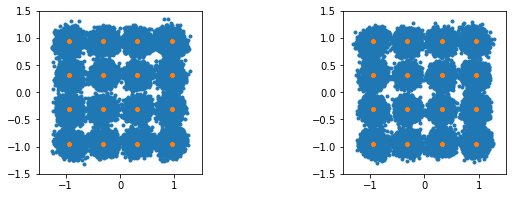

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1000

ax1.plot(y_EQ[discard:-discard,0].real, y_EQ[discard:-discard,0].imag,'.')
ax1.plot(d[:,0].real, d[:,0].imag,'.')
ax1.axis('square')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(y_EQ[discard:-discard,1].real, y_EQ[discard:-discard,1].imag,'.')
ax2.plot(d[:,1].real, d[:,1].imag,'.')
ax2.axis('square')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5);

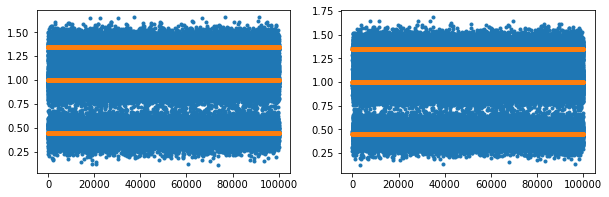

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1

ax1.plot(np.abs(y_EQ[discard:-discard,0]),'.')
ax1.plot(np.abs(d[:,0]),'.');
#ax1.axis('square')
#ax1.set_xlim(-1.5, 1.5)
#ax1.set_ylim(-1.5, 1.5)

ax2.plot(np.abs(y_EQ[discard:-discard,1]),'.')
ax2.plot(np.abs(d[:,1]),'.');
#ax2.axis('square')
#ax2.set_xlim(-1.5, 1.5)
#ax2.set_ylim(-1.5, 1.5);

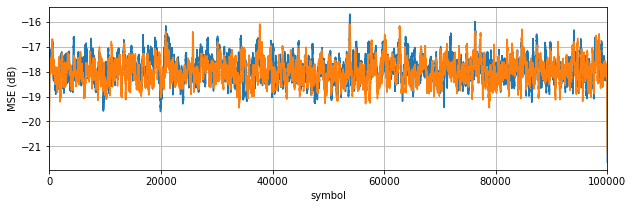

In [45]:
Nav = 200
h = np.ones(Nav)/Nav

plt.figure()
for ind in range(0, errSq.shape[0]):
    err_ = errSq[ind,:]
    plt.plot(10*np.log10(firFilter(h, err_)));
    
# for ind in range(0, errSq.shape[0]):
#     err_ = errSq[ind,:]
#     plt.plot(10*np.log10(np.convolve(h, err_)));

plt.grid()
plt.xlim(0,errSq.shape[1])
plt.xlabel('symbol')
plt.ylabel('MSE (dB)');

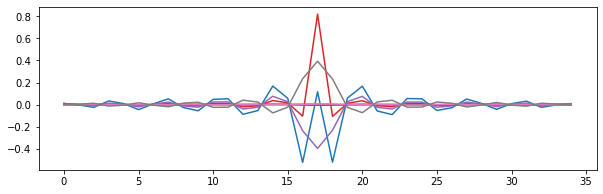

In [46]:
plt.plot(H.real.T,'-');
plt.plot(H.imag.T,'-');

# plt.stem(H[0,:].real.T,linefmt='r');
# plt.stem(H[3,:].imag.T,linefmt='b');

In [47]:
#!pip install line_profiler

In [48]:
%load_ext line_profiler

ModuleNotFoundError: No module named 'line_profiler'

In [ ]:
%lprun -f MIMO_NLMS_v1 MIMO_NLMS_v1(x, d, paramEq)

In [ ]:
a = np.convolve(h, err_)
a.shape

In [ ]:
BER.round(3)

In [ ]:
err_.shape

In [ ]:
errSq.shape
x.shape

In [ ]:
help(firFilter)

In [ ]:
Ex, Ey = pbs(y_EQ[:,0], θ=np.pi/2)

fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1000

ax1.plot(Ex[discard:-discard].real, Ex[discard:-discard].imag,'.')
ax1.plot(d[:,0].real, d[:,0].imag,'.')
ax1.axis('square')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(Ey[discard:-discard].real, Ey[discard:-discard].imag,'.')
ax2.plot(d[:,1].real, d[:,1].imag,'.')
ax2.axis('square')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5);

In [ ]:
@njit
def fastFIRfilter(h, x):   
    """
    Fast FIR filtering with numba
    
    """
    h = h+1j*0
    x = x+1j*0
    
    y    = x.copy()
    y[:] = np.nan
    ind  = np.arange(0, h.size)
    
    Lpad    = int(np.floor(h.size/2))
    zeroPad = np.zeros((Lpad, x.shape[1]))
    x = np.concatenate((zeroPad, x, zeroPad)) # pad start and end of the signal with zeros
    
    for m in range(0, x.shape[1]):
        for k in range(0, x.shape[0]):
            y[k, m] = np.vdot(h, x[ind+k,m])
            
    return y        

In [ ]:
h = np.array([0.001, 0.01, 1, 0.01, 0.001])
a = firFilter(h, y_EQ)

plt.plot(np.abs(a[0:20,1]),'.')
plt.plot(np.abs(y_EQ[0:20,1]),'x')

In [ ]:
plt.plot(np.abs(d[0:20,1]),'.')
plt.plot(np.abs(x[0:40:2,1]),'x')